In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import dependencies
import numpy as np
from numpy import loadtxt
import pandas as pd
from collections import Counter
import sqlalchemy
from sqlalchemy import create_engine, text


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.metrics import classification_report_imbalanced



# LOAD DATA

In [4]:
df_encoded = pd.read_csv('df_encoded.csv')

# Define Features and Target and Split and Scale Data

In [5]:
# Create features
X = df_encoded.drop(columns = ["spe_method", "structure_id"])

# Create target
y = df_encoded["spe_method"]

In [6]:
# Normal train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [7]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled

array([[-0.23601421, -0.23375002,  0.48955629, ..., -0.59315847,
        -0.64066596, -1.15652533],
       [-0.7835774 , -0.78252458,  1.0243091 , ..., -0.59315847,
        -0.64066596,  0.04547282],
       [ 2.0575004 ,  2.06085669, -1.30592787, ..., -0.59315847,
        -0.64066596,  0.04547282],
       ...,
       [-0.65166017, -0.65066704,  0.62824528, ..., -0.59315847,
        -0.64066596, -1.15652533],
       [-1.29642992, -1.29611669,  1.4488616 , ...,  1.16197089,
         1.05282772, -1.15652533],
       [-0.24719506, -0.24515829,  1.56059483, ...,  1.16197089,
         1.05282772, -1.15652533]])

# Test Machine Learning Models

In [12]:
# Train BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators = 100, random_state = 1)
model.fit(X_train_scaled, y_train)

# Make predictions using test data
y_pred = model.predict(X_test_scaled)

# Calculate balanced accuracy score
ba_score = balanced_accuracy_score(y_test, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ["Actual HLB", "Actual MCX"], columns = ["Predicted HLB", "Predicted MCX"])

# Generate imbalanced classification report
ic_report = classification_report_imbalanced(y_test, y_pred)

# Display model performance metrics
print(f"Balanced Accuracy Score: {ba_score}\n\n")
print(f"Confusion Matrix:")
display(cm_df)
print(f"\n\nImbalanced Classification Report: \n\n{ic_report}")

Balanced Accuracy Score: 0.9009433962264151


Confusion Matrix:


,Predicted HLB,Predicted MCX
Actual HLB,48,5
Actual MCX,22,190




Imbalanced Classification Report: 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.91      0.90      0.78      0.90      0.81        53
          1       0.97      0.90      0.91      0.93      0.90      0.81       212

avg / total       0.92      0.90      0.90      0.90      0.90      0.81       265



In [13]:
# List features sorted in descending order by feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame(sorted(zip(importances, X.columns), reverse = True), columns = ["Importance", "Feature"])
# feature_importance_df = pd.DataFrame(feature_importance_list, columns = ["Importance", "Feature"])
feature_importance_df.head()

,Importance,Feature
0,0.076235,SMR_VSA10
1,0.073084,FractionCSP3
2,0.052767,TPSA
3,0.043958,MolMR
4,0.036784,NumValenceElectrons


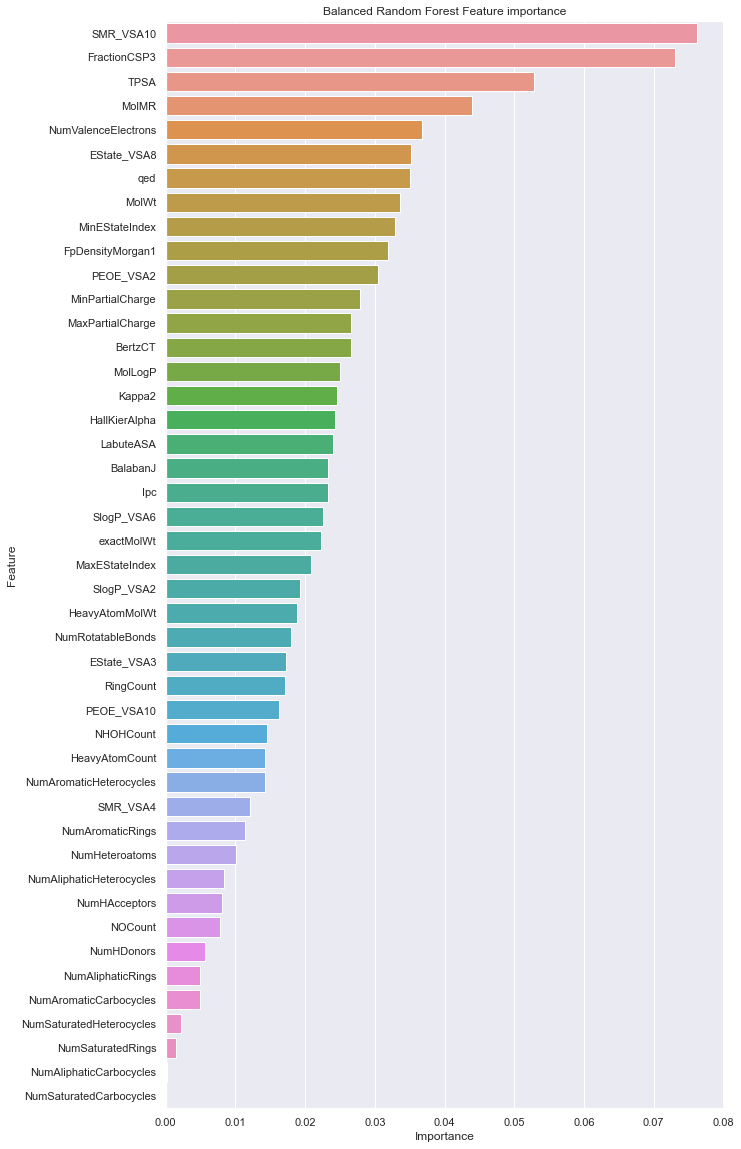

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# create plot
sns.barplot(y = 'Feature', x = 'Importance', data = feature_importance_df)
plt.title('Balanced Random Forest Feature importance')
sns.set(rc={"figure.figsize":(10, 20)}) #width=10, #height=20
plt.show()

# Save Model Using Pickle

In [15]:
import pickle
# save the model to disk
filename = 'finalized_model_spe.sav'
pickle.dump(model, open(filename, 'wb'))